Pytorch implementation for Semantic Segmentation/Scene Parsing on MIT ADE20K dataset 
https://github.com/CSAILVision/semantic-segmentation-pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log"""



From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [ ]:
import shutil
%cp -r /content/drive/MyDrive/ml/MITADE20K /content/

In [ ]:
# System libs
import os
os.chdir('/content/MITADE20K')
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None, visualize = True):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        #print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    if visualize:
      display(PIL.Image.fromarray(im_vis))
    return pred_color

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [ ]:
import numpy as np

# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('/content/tlv.jpg').convert('RGB')



img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

In [ ]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)
print(pred)

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 6 6 6]
 [1 1 1 ... 6 6 6]
 [1 1 1 ... 6 6 6]]


[  1   2   6   4  20  87   9  17  32  43  11  93  48   5  13  14  61  27
 123 104  84  38 107  47 110  28  29  30  31  49 109  33  34  35  36  37
  25  39  40  41  42 108  44  45  46  26  24  51 115 121 120   3 119 118
 117   7   8 116  10  12  23 114 113  15  16 112  18  19 111  21  22  50
  52 103  91  80  81  82  83  85  86 106  88  89  90  92  78 105  94  95
  96  97  98  99 100 101 102  79  77  53  64  54  55  56  57  58  59  60
 122  62  63  65  76  66  67  68  69  70  71  72  73  74  75   0]
building:


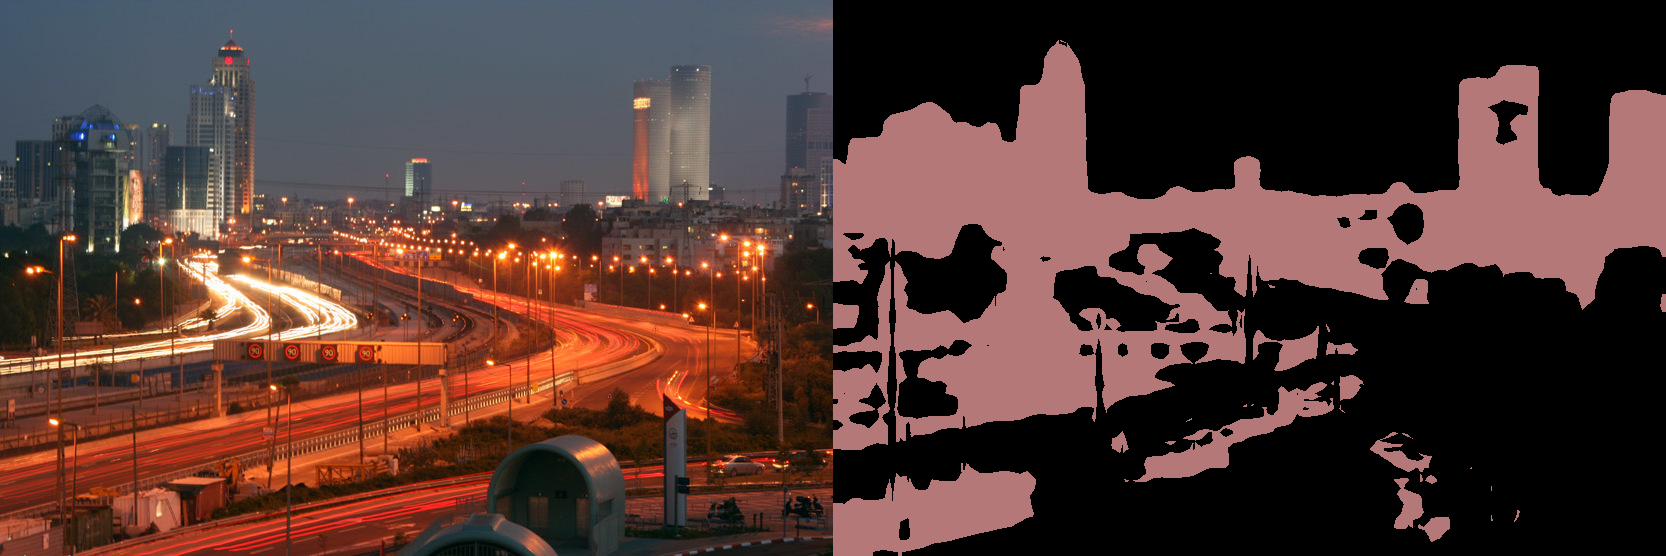

sky:


road:


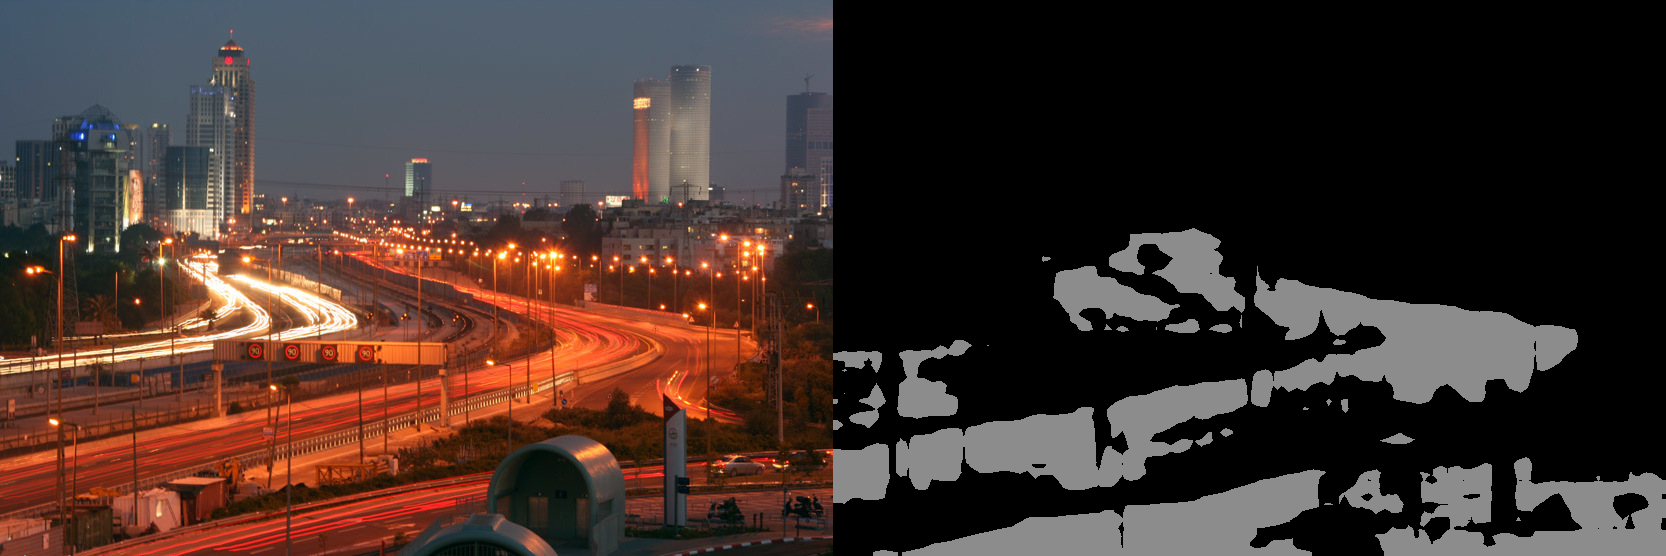

tree:


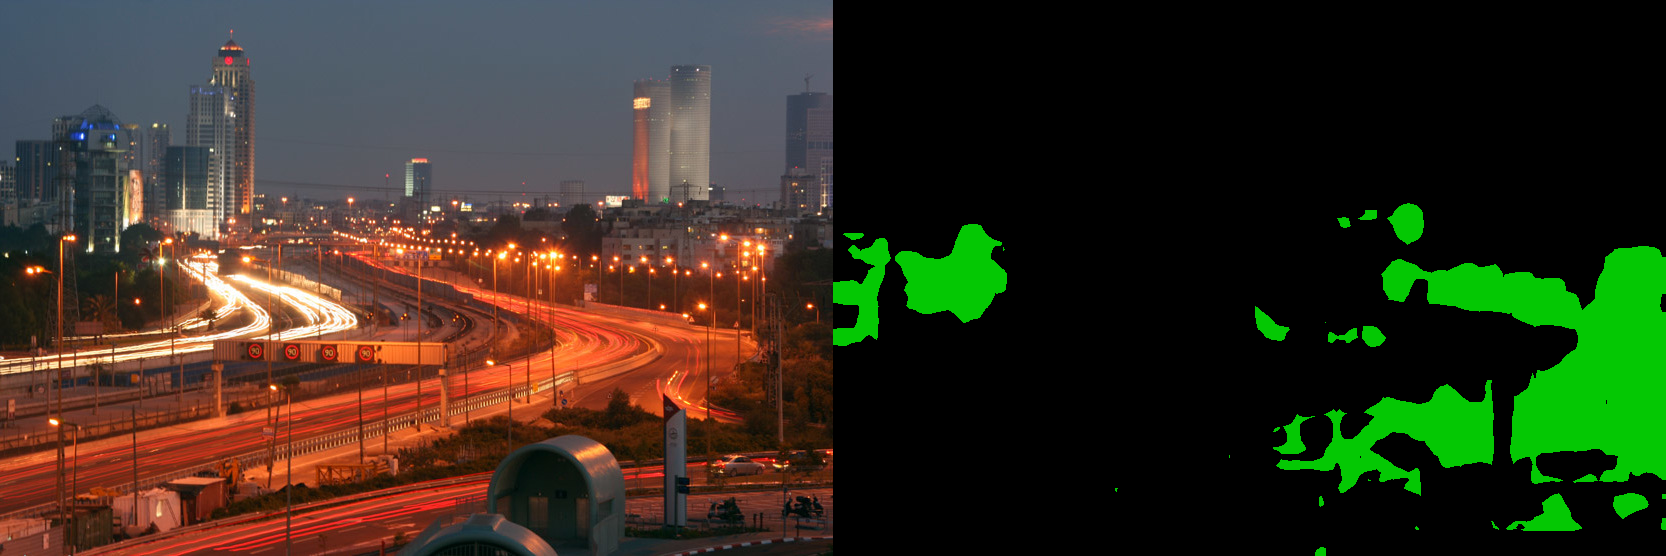

In [ ]:
# Top classes in answer
predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
print(predicted_classes)
for c in predicted_classes[:4]:
    visualize_result(img_original, pred, c)

# On very big images using patchify

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import numpy as np
from patchify import patchify, unpatchify
from PIL import Image

from keras.models import load_model

#model = load_model("models/satellite_standard_unet_100epochs.hdf5", compile=False)
#from smooth_tiled_predictions import predict_img_with_smooth_windowing

# input image
image = Image.open("/content/big_image.jpg").convert('RGB')
image = np.asarray(image)

# splitting the image into patches
image_height, image_width, channel_count = image.shape
patch_height, patch_width, step = 512, 512, 512
patch_shape = (patch_height, patch_width, channel_count)
patches = patchify(image, patch_shape, step=step)
#print(patches.shape)

# processing each patch
output_patches = np.empty(patches.shape).astype(np.uint8)
output_patches_real_photo = np.empty(patches.shape).astype(np.uint8)
output_patches_color_one = np.empty(patches.shape).astype(np.uint8)
output_patches_one_color = np.empty(patches.shape).astype(np.uint8)
preds_img = np.empty(patches.shape).astype(np.uint8)
preds_img = []
one_color = [0,0,0,0,0,0,0,0,0,0]
#np.empty((patch_height, patch_width)).astype(np.uint8)
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i, j, 0]
        #output_patch = process(patch)  # process the patch

        img_original = numpy.array(patch)
        img_data = pil_to_tensor(patch)
        singleton_batch = {'img_data': img_data[None].cuda()}
        output_size = img_data.shape[1:]

        # Run the segmentation at the highest resolution.
        with torch.no_grad():
            scores = segmentation_module(singleton_batch, segSize=output_size)
            
        # Get the predicted scores for each pixel
        _, pred = torch.max(scores, dim=1)
        pred = pred.cpu()[0].numpy()
        # Top classes in answer
        predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
        #for c in predicted_classes[:4]:
        
        #print(pred)
        one_color[0] = visualize_result(img_original, pred, 1,False)# building
        one_color[1] = visualize_result(img_original, pred, 2,False)# sky
        one_color[2]= visualize_result(img_original, pred, 4,False)# tree
        one_color[3]= visualize_result(img_original, pred, 6,False)# road
        one_color[4]= visualize_result(img_original, pred, 9,False)# Grass
        one_color[5]= visualize_result(img_original, pred, 16,False)# mountain
        one_color[6]= visualize_result(img_original, pred, 26,False)# sea
        pred_color = visualize_result(img_original, pred, visualize = False)#wall
        
        #preds_img += pred
        #print(pred.shape)
        output_patches[i, j, 0] = pred_color
        output_patches_real_photo[i, j, 0] = patch
        output_patches_one_color[i, j, 0] = one_color[6]

# merging back patches
output_height = image_height - (image_height - patch_height) % step
output_width = image_width - (image_width - patch_width) % step
output_shape = (output_height, output_width, channel_count)
output_image = unpatchify(output_patches, output_shape)
output_image = Image.fromarray(output_image)

output_image.save("output.jpg")

output_image_real = unpatchify(output_patches_real_photo, output_shape)
output_image_real = Image.fromarray(output_image_real)

output_image_real.save("output_image_real.jpg")

output_image_one_color = unpatchify(output_patches_one_color, output_shape)
output_image_one_color = Image.fromarray(output_image_one_color)

output_image_one_color.save("output_image_one_color.jpg")

#display(output_image_real)
#display(output_image)